<a href="https://colab.research.google.com/github/lizzzb/MovieLens-Data-Analysis-in-Python/blob/main/BatchArchitectureRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Architecture in Recommendation Systems

**Overview:**
Batch architecture is one of the foundational approaches used in building recommendation systems. It focuses on collecting data over a period, processing it in bulk, and generating recommendations for users. This architecture is particularly beneficial **when immediate real-time responses are not critical.**

#### Key Components of Batch Architecture

1. **Data Ingestion**:
   - **Data Sources**: Batch architecture gathers data from various sources, including user interactions, transaction logs, product information, and external datasets.
   - **Storage**: Data is stored in databases or data lakes until it is ready for processing. Common storage solutions include SQL databases, NoSQL databases, or big data platforms like Hadoop.

2. **Data Processing**:
   - **Compute Environment**: The collected data is processed using computational frameworks such as Apache Spark, Apache Flink, or traditional virtual machines.
   - **Feature Engineering**: This step involves transforming raw data into features that will be useful for the recommendation algorithms. This may include user profiling, item characteristics, and interaction histories.

3. **Model Training**:
   - **Algorithm Selection**: Various machine learning algorithms are applied to the prepared dataset to identify patterns and relationships between users and items. Popular algorithms include collaborative filtering (user-based or item-based), matrix factorization, and content-based filtering.
   - **Hyperparameter Tuning**: The selected algorithms are fine-tuned through experimentation to optimize their performance based on offline metrics like precision, recall, and NDCG.

4. **Generating Recommendations**:
   - **Scoring**: Once the best-performing model is identified, it generates a list of recommendations for each user, typically scoring a top-k set of items (e.g., 10 to 50).
   - **Output Format**: The recommendations are usually formatted as a table, with each row representing a user and corresponding recommended items.

5. **Storage of Recommendations**:
   - The generated recommendation table is stored in a database for easy retrieval. This allows for efficient querying when users request recommendations.

6. **Serving Recommendations**:
   - The recommendations are served to the front end of the application through database queries. This is typically a straightforward process, allowing users to access their personalized recommendations with minimal latency.

7. **Business Rules Application** (Optional):
   - Business rules can be applied to filter the recommendations further before serving them to users. Examples include:
     - Removing items that are out of stock.
     - Excluding items not available in the user's region.
     - Considering seasonal trends or promotions.

#### Advantages of Batch Architecture

- **Simplicity**: Easy to implement and manage, making it suitable for teams with limited resources or expertise.
- **Flexibility**: Supports the use of various machine learning algorithms, allowing for thorough experimentation.
- **Efficient Resource Utilization**: Batch processing can optimize resource usage by handling large datasets in one go rather than processing data in real-time.
- **Fast Query Response Times**: Once recommendations are generated and stored, serving them to users can be done quickly through efficient database queries.

#### Disadvantages of Batch Architecture

- **Static Recommendations**: Since recommendations are generated in bulk, they may not reflect users' real-time behaviors or preferences, leading to outdated suggestions.
- **Delayed Adaptation**: Changes in user preferences or item availability may not be accounted for until the next batch processing cycle, which could be daily or weekly.
- **Lack of Real-Time Feedback**: This architecture does not adapt to user interactions or feedback during a single session, potentially reducing user engagement.

#### Conclusion

Batch architecture provides a straightforward and effective way to deploy recommendation systems, particularly when immediate real-time responses are not essential. While it has its limitations, particularly in adapting to dynamic user behavior, it remains a valuable approach for many applications, especially in scenarios where users’ preferences can be analyzed over time. As the system matures, organizations may consider transitioning to more advanced architectures (like real-time or hybrid) to improve user experience and engagement.

###Types of Architectures in Recommendation Systems

Batch architecture is one of several architectural approaches used in recommendation systems. Other types include:

- Real-Time Architecture:
 In this architecture, the recommendation model is deployed in a production environment where it can process user requests in real-time. **Every time a user interacts with the system, the model scores items based on their current behavior and provides instant recommendations.** This approach is more complex but allows for highly personalized and timely suggestions.

- Hybrid Architecture:
 This combines the strengths of both batch and real-time architectures. **In the first phase, a batch process generates a set of candidate items for each user (using heavy machine learning algorithms). In the second phase, a lightweight, real-time algorithm re-ranks these candidates based on recent user interactions.** This approach aims to balance the computational efficiency of batch processing with the responsiveness of real-time processing.

- Streaming Architecture:
This architecture focuses on processing data in real-time as it arrives. It is particularly useful for applications where user behavior changes frequently and immediate recommendations are necessary. Streaming architectures utilize technologies like Apache Kafka or Apache Flink to handle continuous data streams.



In this notebook we are going to explain how to create and use the batch architecture to deploy a recommendation system solution.

The batch architecture is the most common architecture used in recommendation systems. **It is based on the idea of creating a batch process that will run periodically to update the recommendations. It is very common in the industry to run the process every night.**

The batch process will 1) read the data from the data sources, 2) train a machine learning algorithm, 3) score the model to produce the top k recommendations for every user, and finally, 4) store the recommendations in a dataset.

Once the data is in the database, 5) it can be query from the front end of the website or via an internal backend process. **The recommendations will be shown to the user by just doing a SELECT into the database.** This process is very fast, it can be implemented in single digit milliseconds. A reduced query time can be beneficial for the user experience.

In [1]:
# Global Settings and Imports

!pip install recommenders

  Using cached pandera-0.20.4-py3-none-any.whl.metadata (15 kB)
Using cached pandera-0.20.4-py3-none-any.whl (259 kB)
  Attempting uninstall: pandera
    Found existing installation: pandera 0.7.1
    Uninstalling pandera-0.7.1:
      Successfully uninstalled pandera-0.7.1


In [2]:
pip install pandera==0.7.1

  Using cached pandera-0.7.1-py3-none-any.whl.metadata (10 kB)
Using cached pandera-0.7.1-py3-none-any.whl (165 kB)
  Attempting uninstall: pandera
    Found existing installation: pandera 0.20.4
    Uninstalling pandera-0.20.4:
      Successfully uninstalled pandera-0.20.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
recommenders 1.2.0 requires pandera[strategies]>=0.15.0; python_version >= "3.9", but you have pandera 0.7.1 which is incompatible.


In [3]:
import numpy as np
import logging
import sqlite3

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.sar import SAR

Setting Up Logging

1. Import the Logging Module: This module allows you to log messages at different severity levels (e.g., DEBUG, INFO, WARNING, ERROR, CRITICAL).
2. Configure Logging: You can specify the format, level, and destination of your log messages (console, file, etc.).

Using SQLite3

1. Import the SQLite3 Module: This module provides an interface to SQLite databases.
2. Establish a Connection: Connect to a SQLite database file or create one if it doesn't exist.
3. Execute SQL Commands: You can execute SQL commands to create tables, insert data, and query the database.

In [13]:
# Top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = "100k"

# Other data settings
USER_COL = "userID"
ITEM_COL = "itemID"
RATING_COL = "rating"
TIMESTAMP_COL = "timestamp"
PREDICTION_COL = "prediction"

# Model settings
SIMILARITY_TYPE = "jaccard"
TIME_DECAY = 30 # number of days until the weight of the ratings are decayed by 1/2
SEED = 42

# Database parameters
DATABASE = "recodb"
TABLE_NAME = "recommendations"

logging.basicConfig(level=logging.DEBUG, format="%(asctime)s %(levelname)-8s %(message)s")
logging.basicConfig(level=logging.DEBUG)


    DATABASE = "recodb" sets the database name to "recodb".
    TABLE_NAME = "recommendations" sets the table name to "recommendations".


## 1. Data Preparation

In [14]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE
)

# Convert the float precision to 32-bit in order to reduce memory consumption
data[RATING_COL] = data[RATING_COL].astype(np.float32)

data.head()

100%|██████████| 4.81k/4.81k [00:00<00:00, 9.18kKB/s]


,userID,itemID,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


## 2. Model Scoring

We are going to score all the data using SAR. **Notice first that we are not doing any train/test split. In production, we want to use all the available data.**

The model can be trained offline and then deployed into production. Depending on the behavior of your model or your data, there might be a degradation of the performance over time. It is a good practice to retrain the model periodically.


In [18]:

model = SAR(
    col_user=USER_COL,
    col_item=ITEM_COL,
    col_rating=RATING_COL,
    col_timestamp=TIMESTAMP_COL,
    similarity_type=SIMILARITY_TYPE,
    time_decay_coefficient=30,
    timedecay_formula=True,
    normalize=True
)

with Timer() as train_time:
    model.fit(data)

print(f"Took {train_time.interval} seconds for training.")

Took 2.3922253470000214 seconds for training.


In [19]:
with Timer() as scoring_time:
  top_k = model.recommend_k_items(data, top_k=TOP_K, remove_seen=True)
print("Took {} seconds for scoring.".format(scoring_time.interval))

Took 0.46507261599981575 seconds for scoring.


`recommend_k_items` is a method of the SAR model class in the recommenders library. It's used to generate the top k item recommendations for each user in your dataset.

In [20]:
top_k.sort_values(by="prediction", ascending=False, inplace=True)
top_k.head(50)

,userID,itemID,prediction
5230,532,69,4.665657
5231,532,172,4.645321
5232,532,423,4.643408
8460,849,204,4.628795
5233,532,174,4.619922
2140,118,195,4.619201
9190,928,174,4.594107
2141,118,183,4.583690
5234,532,385,4.578142
2142,118,89,4.577481


In [22]:
top_k_recommendations = top_k.groupby("userID").head(TOP_K)
top_k_recommendations

,userID,itemID,prediction
5230,532,69,4.665657
5231,532,172,4.645321
5232,532,423,4.643408
8460,849,204,4.628795
5233,532,174,4.619922
...,...,...,...
6775,685,245,1.496370
6776,685,307,1.482737
6777,685,313,1.475710
6778,685,294,1.466042


In [24]:
user_id = 54
items_seen = data[data[USER_COL] == user_id]
items_seen #the data the user 54 has interacted with

,userID,itemID,rating,timestamp
232,54,106,3.0,880937882
336,54,595,3.0,880937813
512,54,742,5.0,880934806
806,54,302,4.0,880928519
1352,54,676,5.0,880935294
...,...,...,...,...
68542,54,634,1.0,892681013
70980,54,250,4.0,880933834
74116,54,823,2.0,880938088
78663,54,405,4.0,880934806


In [25]:
items_predicted=top_k[top_k[USER_COL]==user_id].sort_values(by=PREDICTION_COL, ascending=False)

items_predicted

,userID,itemID,prediction
1300,54,300,2.784323
1301,54,294,2.601673
1302,54,248,2.548543
1303,54,286,2.458506
1304,54,282,2.436808
1305,54,271,2.433754
1306,54,293,2.368300
1307,54,315,2.367518
1308,54,222,2.357715
1309,54,301,2.354047


`top_k[top_k[USER_COL] == user_id]`: This selects rows from the top_k DataFrame where the user ID matches the specified user_id (which is 54 in your previous code).

This DataFrame now contains the predicted items for user 54, sorted from highest to lowest predicted score.

The model is recommending items that the user has not interacted with before.

This is actually the expected behavior of a recommendation system. The goal is to suggest new and relevant items that the user might like, not just reiterate items they have already seen.

## 3. Batch Deployment

The batch deployment is storing the result in a database to be accessible for an external process.

This notebook uses SQLite as a database, however, any other relational or non-relational database can be used.

In the context of databases, a cursor is a control structure that enables traversal over the records in a database. You can think of it as a pointer that allows you to fetch and process data from a result set one row at a time.

Here's a simple analogy: imagine a table with many rows of data. The cursor acts like your finger, pointing to one row at a time as you read through the table.

Here are some common operations you can perform with a cursor:

    Execute a query: A cursor is used to execute SQL queries against the database.
    Fetch data: After executing a query, you use the cursor to retrieve the results. This can be done one row at a time or in batches.
    Modify data: Cursors can also be used to update or delete data in the database.

Cursor ist ein Iterator, der einer Anfrage (Ergebnisrelation) zugeordnet wird
und mit dessen Hilfe die Sätze der Ergebnismenge einzeln (one tuple at a
time) im Programm bereitgestellt werden.

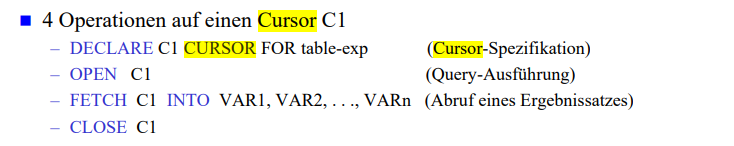

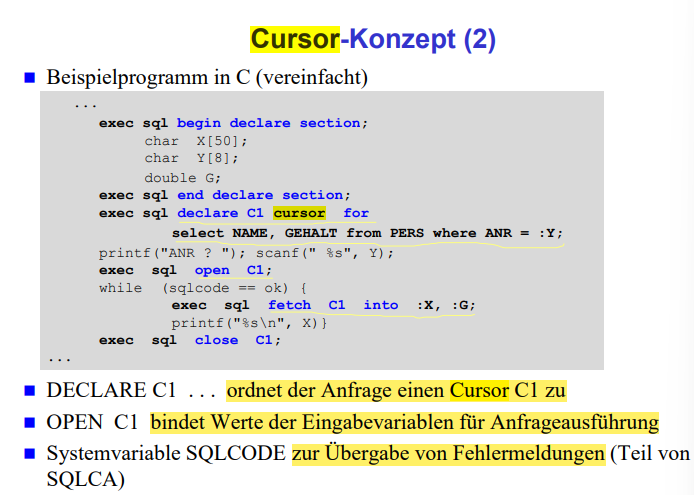

In [40]:
# Establish a connection to the database
con = sqlite3.connect(database=DATABASE)

# Create a cursor object to execute SQL queries
cur = con.cursor()

# Drop table if already exists
query = "DROP TABLE IF EXISTS " + TABLE_NAME + ";"
cur.execute(query)

# Create a table to store your data
create_table_query = f"""
CREATE TABLE {TABLE_NAME} (
  user_id INT PRIMARY KEY,
  item1 TEXT,
  item2 TEXT,
    item3 TEXT,
    item4 TEXT,
    item5 TEXT,
    item6 TEXT,
    item7 TEXT,
    item8 TEXT,
    item9 TEXT,
    item10 TEXT
);
"""
cur.execute(create_table_query)

# Commit the changes and close the connection
con.commit()


# Create a function to prepare and return the data for insertion
def prepare_data(user_group):
  user_id = user_group.name
  recommendations = user_group["itemID"].tolist()
  recommendations.extend([None]* (TOP_K - len(recommendations)))# Fill empty slots with NULL
  return (user_id, *recommendations)

# Use apply and groupby to efficiently generate the insert_data list
insert_data = top_k_recommendations.groupby("userID").apply(prepare_data).tolist()

Let's break down each line of the code:

### 1. **Establish a connection to the database**
```python
con = sqlite3.connect(database=DATABASE)
```
- **Explanation**: This line establishes a connection to the SQLite database. The variable `DATABASE` refers to the name or path of the database file. If the database file doesn't exist, SQLite will create it. The `con` variable is the connection object that allows you to interact with the database (execute queries, commit changes, etc.).

### 2. **Create a cursor object to execute SQL queries**
```python
cur = con.cursor()
```
- **Explanation**: This line creates a cursor object, `cur`, from the connection object `con`. The cursor is used to execute SQL queries and fetch results from the database. It acts as a mediator between the SQLite connection and the operations you perform on the database.

### 3. **Drop table if already exists**
```python
query = "DROP TABLE IF EXISTS " + TABLE_NAME + ";"
cur.execute(query)
```
- **Explanation**:
  - `DROP TABLE IF EXISTS`: This SQL command deletes the table named `TABLE_NAME` from the database if it already exists. The use of `IF EXISTS` ensures that no error is thrown if the table doesn't exist.
  - `TABLE_NAME`: This is a variable that holds the name of the table. The `+` operator concatenates this variable with the SQL query string.
  - `cur.execute(query)`: Executes the `DROP TABLE` query via the cursor object `cur`.

### 4. **Create a table to store your data**
```python
create_table_query = f"""
CREATE TABLE {TABLE_NAME} (
  user_id INT PRIMARY KEY,
  item1 TEXT,
  item2 TEXT,
  item3 TEXT,
  item4 TEXT,
  item5 TEXT,
  item6 TEXT,
  item7 TEXT,
  item8 TEXT,
  item9 TEXT,
  item10 TEXT
);
"""
cur.execute(create_table_query)
```
- **Explanation**:
  - `CREATE TABLE {TABLE_NAME}`: This SQL command creates a new table named `TABLE_NAME`. The curly braces `{}` in the string are part of an **f-string** in Python, allowing the variable `TABLE_NAME` to be inserted directly into the query.
  - **Columns**:
    - `user_id INT PRIMARY KEY`: This defines the `user_id` column as an integer (`INT`), and it is the primary key of the table. The primary key uniquely identifies each row in the table.
    - `item1 TEXT` to `item10 TEXT`: These are columns that store text data (`TEXT`), representing different items. The table has 10 text columns in total.
  - `cur.execute(create_table_query)`: Executes the `CREATE TABLE` query using the cursor object to create the new table.

### 5. **Commit the changes and close the connection**
```python
con.commit()
```
- **Explanation**: This line commits the changes to the database. Any SQL commands executed before this point (such as creating or dropping tables) are finalized and saved to the database. Without committing, changes are not permanent and could be lost if the connection is closed or the program crashes.

----

1. **The Problem**:
   - You have a list of recommendations for users, but each user might have a different number of recommendations.
   - You want to **prepare this data** so that every user has exactly the same number of recommendations (`TOP_K`), even if some users have fewer recommendations. For users with fewer recommendations, you need to fill the empty spots with `None`.

2. **The Goal**:
   - For each user, you want to create a list like this: `(userID, item1, item2, ..., itemTOP_K)`.
   - If a user has fewer than `TOP_K` recommendations, fill the extra spots with `None` so each list always has the same length.

#### 1. **The `prepare_data` Function**

```python
def prepare_data(user_group):
    user_id = user_group.name
    recommendations = user_group["itemID"].tolist()  # Get all recommended items for the user as a list.
    recommendations.extend([None] * (TOP_K - len(recommendations)))  # Fill empty slots with None if needed.
    return (user_id, *recommendations)  # Return a tuple with user_id and all recommendations.
```

- **`user_group.name`**: This gets the `userID`. In the code, `user_group` is a subset of the data for one specific user.
  
- **`user_group["itemID"].tolist()`**: This extracts the list of recommended items (e.g., products, movies) for this user.

- **`recommendations.extend([None] * (TOP_K - len(recommendations)))`**:
    - If a user has fewer recommendations than `TOP_K`, this line adds `None` (or `NULL`) to fill up the remaining spaces.
    - For example, if `TOP_K = 5` and the user has only 3 recommendations, it will add 2 `None` values so the list always has 5 items.

- **`return (user_id, *recommendations)`**:
    - This returns a tuple: `(userID, item1, item2, ..., itemTOP_K)`. The `*` symbol "unpacks" the list of items into individual elements in the tuple.

#### 2. **Applying the Function to Grouped Data**

```python
insert_data = top_k_recommendations.groupby("userID").apply(prepare_data).tolist()
```

- **`top_k_recommendations.groupby("userID")`**:
    - This groups the data by `userID`. Each group will contain all the recommendations for one user.
  
- **`.apply(prepare_data)`**:
    - For each group (i.e., each user), the `prepare_data` function is applied. It takes the user’s recommendations and ensures they have exactly `TOP_K` recommendations by adding `None` where necessary.
  
- **`.tolist()`**:
    - The result of applying `prepare_data` to each user group is converted into a list of tuples, where each tuple contains a `userID` and their recommendations.

### An Example to Help Visualize

Let's say your `top_k_recommendations` DataFrame looks like this:

| userID | itemID |
|--------|--------|
| 1      | A      |
| 1      | B      |
| 2      | C      |
| 2      | D      |
| 2      | E      |

Here, `user 1` has only 2 recommendations, and `user 2` has 3 recommendations. Now, assume `TOP_K = 5`.

#### What Does the Code Do?

1. **Grouping by `userID`**:
   - Group 1: `[(1, 'A'), (1, 'B')]`
   - Group 2: `[(2, 'C'), (2, 'D'), (2, 'E')]`

2. **Applying `prepare_data` to Each Group**:
   - For **User 1**, the `prepare_data` function:
     - Takes their recommendations: `['A', 'B']`.
     - Adds `None` for the remaining 3 spots (because `TOP_K = 5`): `['A', 'B', None, None, None]`.
     - Returns: `(1, 'A', 'B', None, None, None)`.
   
   - For **User 2**, the `prepare_data` function:
     - Takes their recommendations: `['C', 'D', 'E']`.
     - Adds `None` for the remaining 2 spots: `['C', 'D', 'E', None, None]`.
     - Returns: `(2, 'C', 'D', 'E', None, None)`.

3. **Final `insert_data` List**:
   - After running the code, the `insert_data` list will look like:
   ```python
   [
       (1, 'A', 'B', None, None, None),
       (2, 'C', 'D', 'E', None, None)
   ]
   ```

Each tuple is ready to be inserted into a database, where each `userID` has exactly 5 recommended items (or `None` if fewer items were available).

### Conclusion

- The code **formats the data** to ensure that every user has a fixed number of recommendations (`TOP_K`).
- It prepares the data in a way that can be directly inserted into a database.
- If some users have fewer than `TOP_K` recommendations, the empty spots are filled with `None` to maintain consistency.

 You never explicitly created the `user_group` subset in your code, but it's automatically generated by the `groupby()` function in pandas. Let me explain how this happens and why you didn't need to declare it yourself.

### How `groupby()` Works

When you use the `groupby("userID")` function in pandas, it splits the DataFrame into smaller groups **internally** based on the unique values in the `userID` column. Each group corresponds to one specific `userID` and contains only the rows for that user.

You don't have to explicitly declare the subsets (`user_group`), because pandas takes care of this internally when you call the `apply()` function.

### Here's how it works:

```python
insert_data = top_k_recommendations.groupby("userID").apply(prepare_data).tolist()
```

- **`groupby("userID")`**:
  - This splits `top_k_recommendations` into groups where each group contains the data for a specific `userID`.
  
- **`apply(prepare_data)`**:
  - The `apply()` method goes through each of these user groups and passes them one by one to the `prepare_data()` function.
  - Each time the `prepare_data()` function is called, it receives one of these groups (a smaller DataFrame with one `userID`) as its argument, which is labeled as `user_group`.

So, **`user_group`** is automatically created by pandas during the process of applying the function to each user group. That's why you don't see it explicitly declared in your code.

### What is `user_group`?

- It’s a DataFrame that contains the rows for just one user. For example, if `userID = 1`, `user_group` might look like this:

  | userID | itemID |
  |--------|--------|
  | 1      | A      |
  | 1      | B      |

  If `userID = 2`, `user_group` would look like this:

  | userID | itemID |
  |--------|--------|
  | 2      | C      |
  | 2      | D      |
  | 2      | E      |

This is how `groupby` and `apply` work together:
1. **`groupby`** splits the DataFrame into groups based on `userID`.
2. **`apply`** sends each group (i.e., each `user_group`) to the `prepare_data()` function for processing.

### Summary

You didn’t need to explicitly declare the `user_group` because **pandas handles the creation of these groups for you** inside the `groupby()` operation. When you call `apply(prepare_data)`, pandas automatically passes each of these user-specific groups to your `prepare_data` function, which then processes them accordingly.

Let me know if you'd like to see more examples or further clarification!

Great question! **`user_group.name`** refers to the **name of the group**, which in this case is the **`userID`**. Let me break it down in the context of the `groupby` operation:

### Explanation of `user_group.name`

When you use `groupby("userID")`, pandas internally groups the data by the unique values in the `userID` column. The **name** of each group is the value of `userID` for that specific group. So, **`user_group.name`** returns the `userID` that corresponds to that group.

### Example:
Suppose your DataFrame `top_k_recommendations` looks like this:

| userID | itemID |
|--------|--------|
| 1      | A      |
| 1      | B      |
| 2      | C      |
| 2      | D      |
| 2      | E      |

When you do `groupby("userID")`, pandas splits the DataFrame into **two groups** based on the unique values in the `userID` column:

1. **Group 1** for `userID = 1`:
   ```python
   userID  itemID
   1       A
   1       B
   ```
   - **`user_group.name`**: In this case, `user_group.name` will be `1` (the `userID` of this group).

2. **Group 2** for `userID = 2`:
   ```python
   userID  itemID
   2       C
   2       D
   2       E
   ```
   - **`user_group.name`**: Here, `user_group.name` will be `2`.

### How It Works in Your Code:
- **`user_group.name`**: For each user group, this gives you the `userID` of that group. So, if `user_group` contains the rows for `userID = 1`, `user_group.name` will return `1`. Similarly, for `userID = 2`, it will return `2`.

### In the Function:

```python
def prepare_data(user_group):
    user_id = user_group.name  # This gets the 'userID' for the current group
    recommendations = user_group["itemID"].tolist()  # List of recommended items for this user
    recommendations.extend([None] * (TOP_K - len(recommendations)))  # Fill with None if fewer than TOP_K items
    return (user_id, *recommendations)  # Return tuple with user_id and list of items
```

- `user_id = user_group.name`: This assigns the `userID` (group name) to the variable `user_id`.
- It’s used to associate the user's `userID` with the list of recommendations that you're preparing.

So, `user_group.name` is a convenient way to access the **group label** (the `userID` in this case) when using the `groupby()` method. You don't need to extract the `userID` manually from the data—it is automatically provided by `user_group.name`.

The executemany() method is used to execute an SQL query multiple times with different sets of parameters.

In [41]:
# Define the SQL statement for the bulk insert
insert_sql = f"""
INSERT INTO {TABLE_NAME} (user_id, item1, item2, item3, item4, item5, item6, item7, item8, item9, item10)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"""

# Use executemany to insert the data in a single transaction
cur.executemany(insert_sql, insert_data)

# Commit the changes
con.commit()

## 3.1 Query the database

Once the data is stored in the database, we can query it. The typical query is to get the top k recommendations for a specific user.


In [42]:
query = f"SELECT * FROM {TABLE_NAME} WHERE user_id = {user_id}"
cur.execute(query)
data = cur.fetchall()
print(data)

[(54, '300', '294', '248', '286', '282', '271', '293', '315', '222', '301')]


 **`data = cur.fetchall()`**
   - **`cur.fetchall()`** retrieves all rows returned by the query execution.
   - **`data`** will be a list of tuples, where each tuple represents a row of data from the table.
   - If there is only one row for the given `user_id`, `data` will contain a single tuple.

### Example:

Assuming the table `recommendations` looks like this:

| user_id | item1 | item2 | item3 | item4 | item5 | item6 | item7 | item8 | item9 | item10 |
|---------|-------|-------|-------|-------|-------|-------|-------|-------|-------|--------|
| 1       | A     | B     | C     | None  | None  | None  | None  | None  | None  | None   |
| 2       | D     | E     | F     | G     | None  | None  | None  | None  | None  | None   |

And if you set `user_id = 1`, the code would run:

```sql
SELECT * FROM recommendations WHERE user_id = 1;
```

The result of `cur.fetchall()` would be:

```python
[(1, 'A', 'B', 'C', None, None, None, None, None, None, None)]
```

So, `data` would store a list with one tuple containing the user's ID and their top-k recommendations.

### Notes on Safety
- **SQL Injection Risk**: This approach of directly formatting the query using `f-strings` can expose your code to **SQL injection attacks** if `user_id` comes from user input. To avoid this, you should use **parameterized queries**.
  
  A more secure way to execute the same query:
  ```python
  query = f"SELECT * FROM {TABLE_NAME} WHERE user_id = ?"
  cur.execute(query, (user_id,))
  ```

This version ensures that `user_id` is safely passed to the query, avoiding potential SQL injection risks.

In [43]:
# Close the database connection
cur.close()
con.close()



The batch architecture is the most common and simple architecture in recommendation systems. It works very well when the data is not changing very often, it is easy to implement, and it has a very low latency.

Real examples of industries using this architecture are retail, media and entertainment, ads, gaming and travel.
